In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.catch_warnings
import torchvision
import cv2 as cv
from tqdm import tqdm

data_path = '/content/drive/MyDrive/Colab Notebooks/iLab Capstone/Remove Hair'

# Hair Removal Function

In [ ]:
def remove_hair(images, cfg=None):
    num_images = len(images)
    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100
                self.edge_high_threshold = 220
                self.dark_spot_threshold = 150
                self.linelength_threshold = 10
                self.divergence_threshold = 0.25
                self.patchiness_threshold = 0.15
                self.interp_win = 20
        cfg = CFG()

    # Adjust subplot creation based on the number of images
    if num_images == 1:
        fig, ax = plt.subplots(1, 6, figsize=(12, 2))
    else:
        fig, ax = plt.subplots(num_images, 6, figsize=(12, 2 * num_images))

    plt.subplots_adjust(wspace=0.01, hspace=0.2)

    # Handle single image plotting
    if num_images == 1:
        ax = np.expand_dims(ax, axis=0)

    for this_ax in ax.ravel():
        this_ax.set_axis_off()

    img_filtered_all = []
    for image_ind, img_orig in enumerate(images):
        image_size = img_orig.shape[:2]

        # Check if input is RGB
        plt.sca(ax[image_ind, 0])
        if img_orig.ndim == 3:
            RGB_input = 1
            img = img_orig.mean(-1)
        else:
            RGB_input = 0
            img = img_orig.copy()
        plt.imshow(img_orig, cmap='gray')
        plt.title('Original')

        skip_flag = 0

        # Edge detection
        plt.sca(ax[image_ind, 1])
        kernel = np.ones((3,3),np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel)
        img_filt = np.where(img_filt > 15, img_filt, 0)
        kernel = np.ones((4,4),np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)
        plt.imshow(img_filt, cmap='gray')
        plt.title('BlackHat')

        # Filter out darker pixels
        plt.sca(ax[image_ind, 2])
        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4),np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)
        img_filt = img_filt * dark_spots
        plt.imshow(img_filt, cmap='gray')
        plt.title('Only darker pixels')

        # Detect long lines
        plt.sca(ax[image_ind, 3])
        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)
        if lines is not None:
            lines = lines.reshape(-1, 4)
            N_lines = lines.shape[0]
            lines_to_interp = []
            for ind in range(N_lines):
                line = lines[ind, :]
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)
                if line_length < cfg.linelength_threshold:
                    plt.scatter(x, y, 30, alpha=0.1, c='green')
                else:
                    plt.scatter(x, y, 1, alpha=0.5, c='red')
                    lines_to_interp.append((x, y))
        else:
            skip_flag = 1
            img_filt = np.zeros(image_size)

        plt.imshow(img_filt, cmap='gray')
        plt.title('Long lines')

        # Final mask for detected hair
        plt.sca(ax[image_ind, 4])
        if skip_flag == 1:
            Mask = np.zeros(image_size)
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1
            kernel = np.ones((3,3),np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel)
            Mask = Mask.astype(float)
            Mask_i_inds, Mask_j_inds = np.where(Mask)
            i, j = np.where(Mask != 0)
            if i.size == 0:
                skip_flag = 1
                Mask = np.zeros(image_size)
            else:
                x_patchinees = np.std(j) / Mask.shape[1]
                y_patchinees = np.std(i) / Mask.shape[0]
                x_divergence = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_divergence = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt(x_patchinees * y_patchinees)
                divergence = np.max([x_divergence, y_divergence])
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    skip_flag = 1
                    Mask = np.zeros(image_size)
        plt.imshow(Mask, cmap='gray')
        plt.title('Final mask')

        # Interpolate the hairs
        plt.sca(ax[image_ind, 5])
        if skip_flag:
            img_filtered = img_orig
        else:
            Mask_temp = 1 - 2 * Mask
            img_filtered = img_orig.copy()
            if RGB_input:
                for channel in range(img_orig.shape[-1]):
                    img_masked = np.squeeze(img_orig[:,:,channel]) * Mask_temp
                    img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
            else:
                img_masked = img_orig * Mask_temp
                img_filtered = fill_image(img_masked, Mask_i_inds, Mask_j_inds)
        plt.imshow(img_filtered, cmap='gray')
        plt.title('Filtered')
        img_filtered_all.append(img_filtered)

    return img_filtered_all

def fill_image(img_masked, i_inds, j_inds, interp_win=10):
    for i, j in zip(i_inds, j_inds):
        if (i>=interp_win) or (j>=interp_win):
            template = img_masked[i: i+2*interp_win, j: j+2*interp_win].flatten()
        elif (img_masked.shape[0] - i < interp_win) or (img_masked.shape[1] - j < interp_win):
            template = img_masked[i-2*interp_win: i, j-2*interp_win: j].flatten()
        else:
            template = img_masked[i-interp_win: i+interp_win, j-interp_win: j+interp_win].flatten()

        template = np.delete(template, (template < 0))
        img_masked[i, j] = np.median( template )
    return img_masked

def fill_line(x, y, step=1):
    points = []
    if x[0] == x[1]:
        ys = np.arange(y.min(), y.max(), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1]-x[0]))
        ys = y[0] + m * (xs-x[0])
    return xs.astype(int), ys.astype(int)

# Load dataset using Torchvision

In [ ]:
train_data = torchvision.datasets.ImageFolder(data_path)

# # Run the algorithm on every image

Processing Images:  26%|██▌       | 8/31 [02:25<05:39, 14.75s/it]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-20ca1e98bf74>:128: RuntimeWarning: invalid value encountered in cast
  img_filtered[:, :, channel] = fill_image(img_masked, Mask_i_inds, Mask_j_inds, interp_win=cfg.interp_win)
Processing Images:  65%|██████▍   | 20/31 [1:09:00<2:41:25, 880.52s/it]<ipython-input-3-20ca1e98bf74>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`

All images processed.


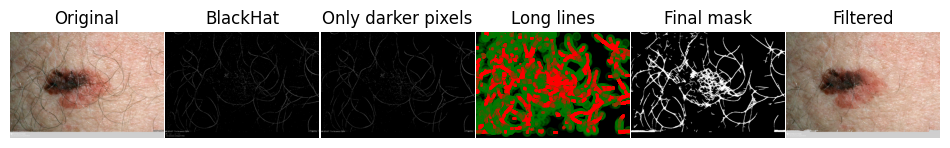

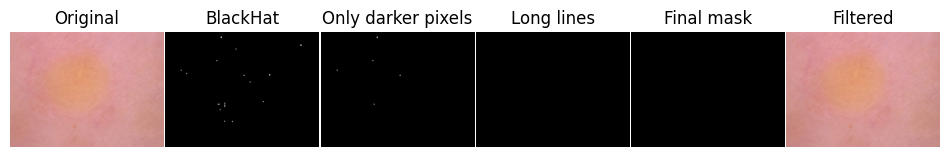

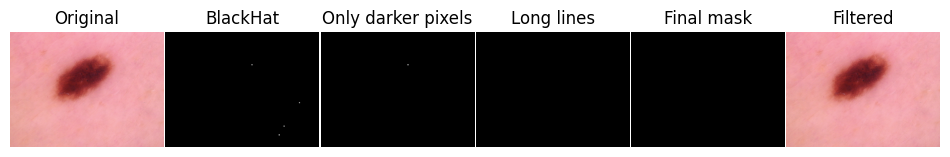

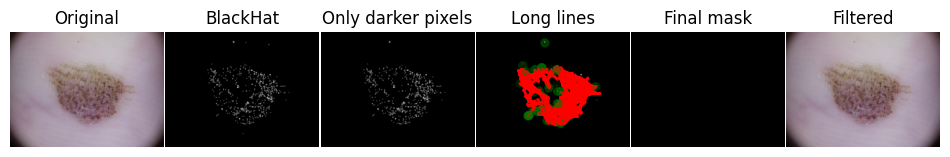

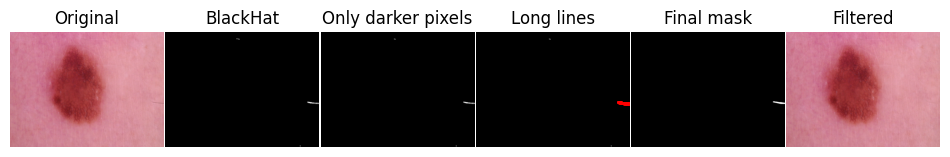

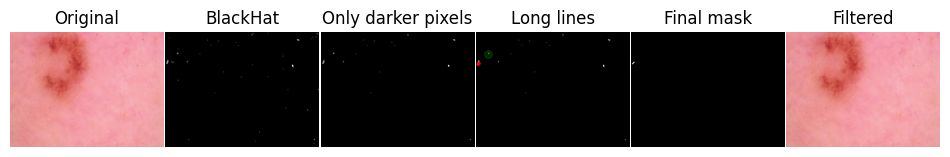

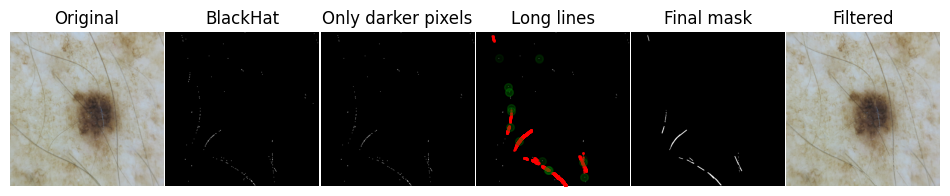

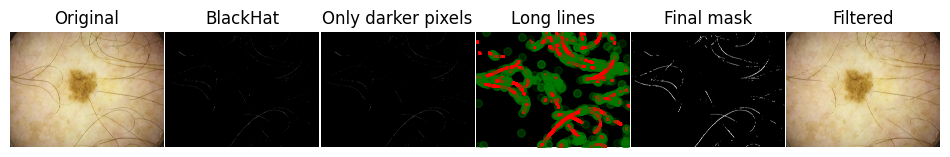

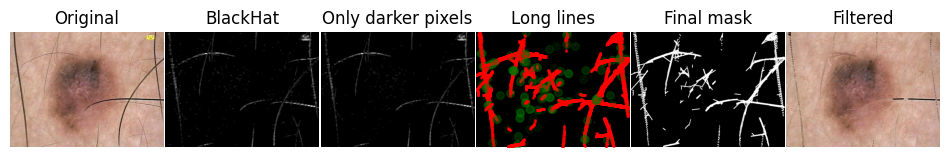

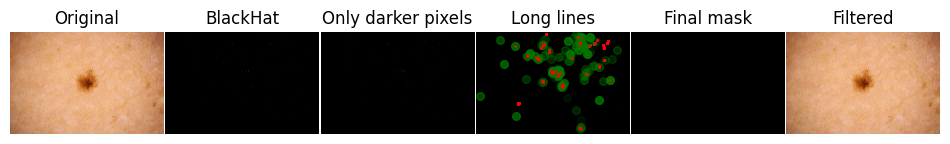

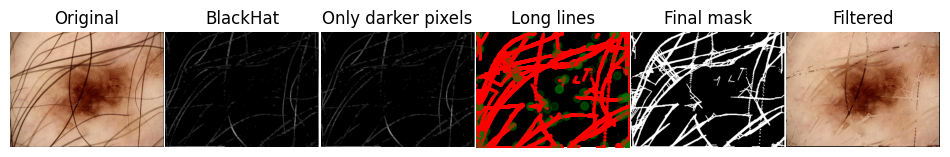

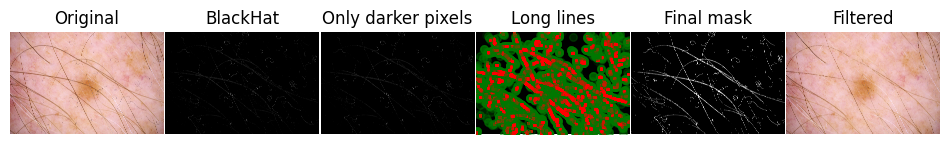

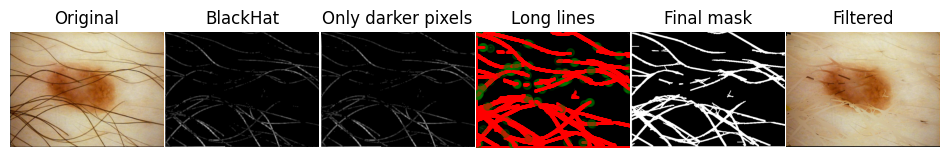

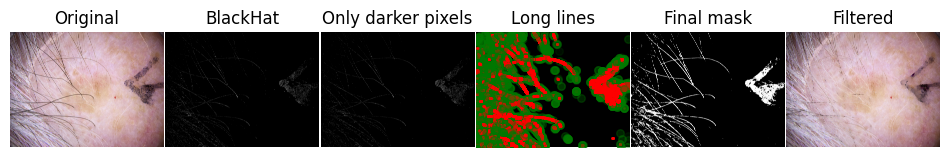

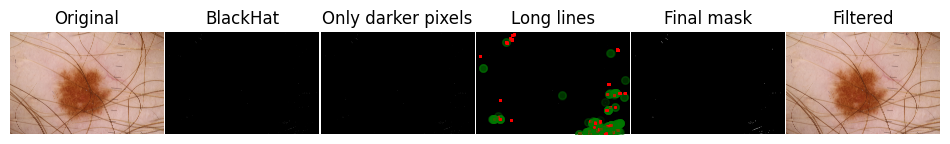

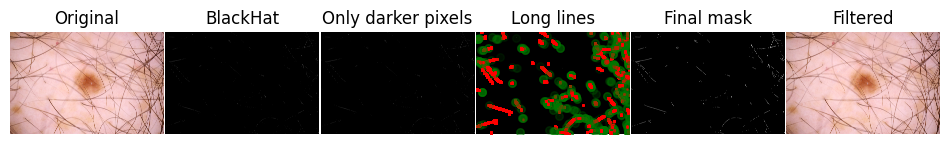

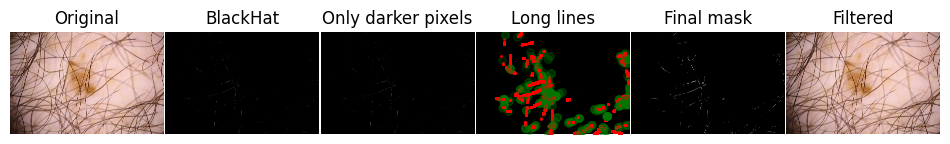

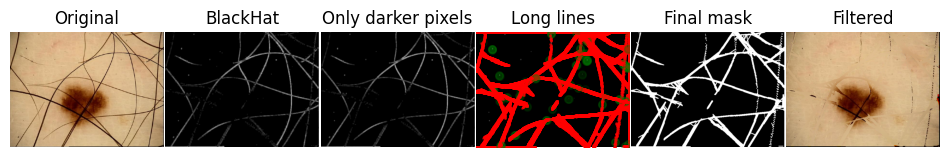

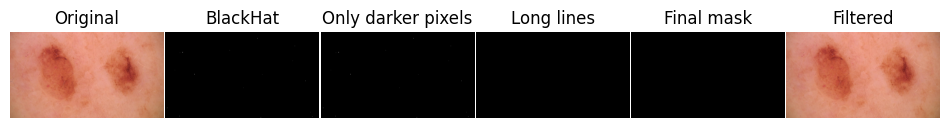

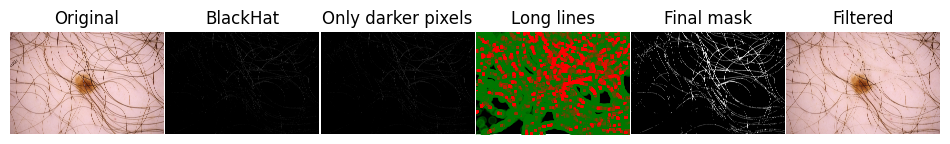

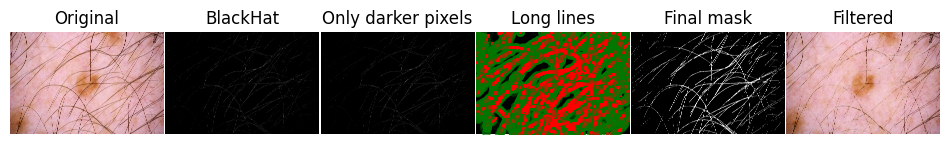

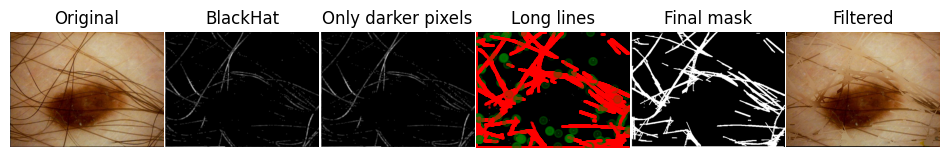

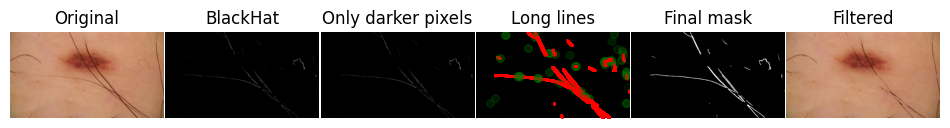

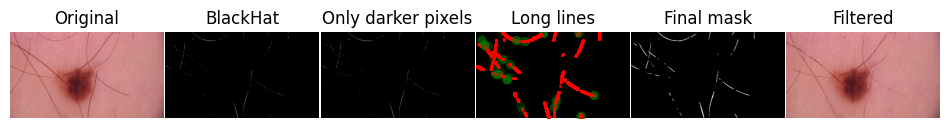

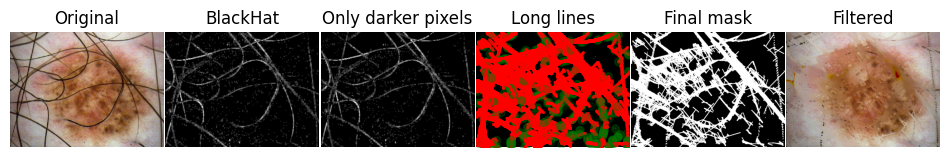

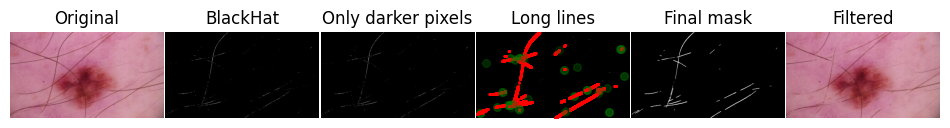

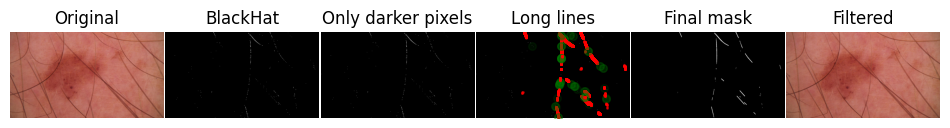

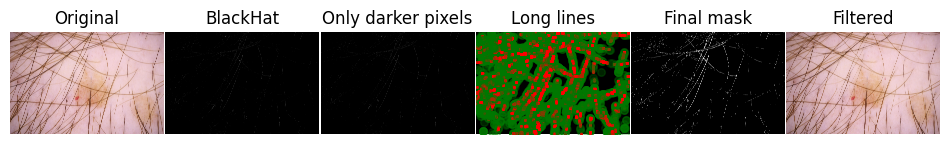

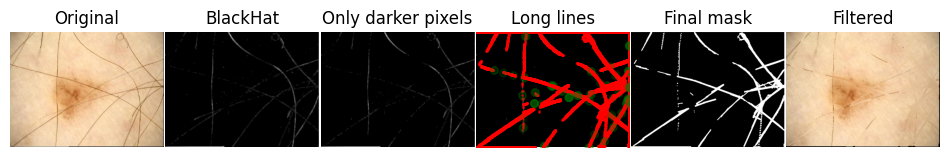

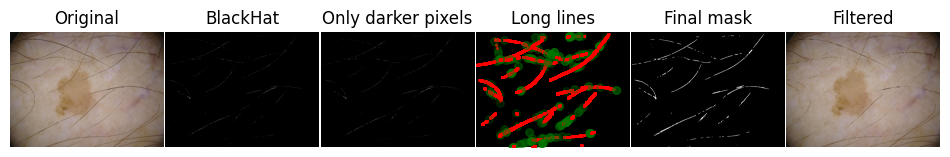

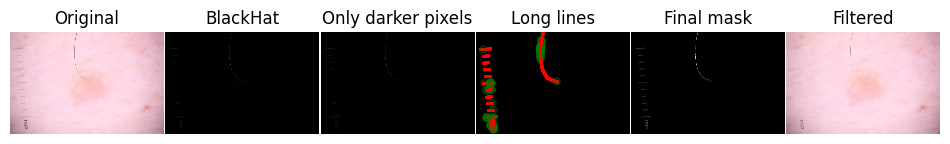

In [ ]:
# Create a directory to save processed images
output_dir = os.path.join(data_path, 'Hair Removed Processed')
os.makedirs(output_dir, exist_ok=True)

# Loop through all images in the dataset with a progress bar
for i in tqdm(range(len(train_data)), desc="Processing Images"):
    # Load the image
    img = np.array(train_data[i][0])

    # Apply hair removal on the single image
    img_no_hair = remove_hair([img])  # Pass the image inside a list

    # Save the processed image
    original_image_name = train_data.imgs[i][0].split('/')[-1]  # Extract the filename
    output_path = os.path.join(output_dir, original_image_name)
    plt.imsave(output_path, img_no_hair[0], cmap='gray')  # Save using the processed image

print("All images processed.")
